In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
def gauss_kernel(size=5, sigma=1.0):
  grid = np.float32(np.mgrid[0:size,0:size].T)
  gaussian = lambda x: np.exp((x - size//2)**2/(-2*sigma**2))**2
  kernel = np.sum(gaussian(grid), axis=2)
  kernel /= np.sum(kernel)
  return kernel

In [ ]:
img=mpimg.imread("/Users/jedi/Projects/deep/DCGAN-tensorflow/data/img_align_celeba/000001.jpg")/255.
#plt.imshow(img)

In [ ]:
newimg = torch.zeros(3,218,178)
for i in range(3):
    _ = torch.from_numpy(img).permute(2,0,1)[i,:,:].unsqueeze(0).unsqueeze(0).float()
    newimg[i,:,:] = F.conv2d(Variable(_), Variable(torch.from_numpy(gauss_kernel()).unsqueeze(0).unsqueeze(0)), padding=2).data.squeeze(0).squeeze(0)

In [ ]:
_ = F.conv2d(Variable(_), Variable(torch.from_numpy(np.array(([matlab_style_gauss2D(ks, 0.1)]*9)).reshape(3,3,ks,ks))).float()).data

In [ ]:
ks=5
_ = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float()
newimg = F.conv2d(Variable(_), Variable(torch.from_numpy(np.array(([gauss_kernel()]*9)).reshape(3,3,ks,ks))), padding=2).data.squeeze(0).squeeze(0)

In [ ]:
#plt.imshow(_.squeeze(0).squeeze(0).numpy())
plt.imshow(newimg.permute(1,2,0).numpy())

In [ ]:
def matlab_style_gauss2D(shape=3,sigma=1.0):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    shape = (shape, shape)
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [ ]:
def gkern(kernlen=4, nsig=1):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [ ]:
import scipy
from scipy import ndimage
plt.imshow(ndimage.filters.gaussian_filter(img, sigma=1.0,mode='nearest', cval=0,truncate=4.0,preserve_range=True))

In [ ]:

_ = torch.from_numpy(img.transpose(2,1,0)).unsqueeze(0).float()
#_ = l(Variable(_)).data#.numpy()
_ = F.conv2d(Variable(_), Variable(torch.from_numpy(np.array(([matlab_style_gauss2D(ks, 0.1)]*9)).reshape(3,3,ks,ks))).float()).data

In [ ]:
import torchvision
torchvision.utils.save_image(_, "temp.png", normalize=True)
img=mpimg.imread("temp.png")
plt.imshow(img)

In [ ]:
import tensorflow as tf
def gauss_kernel(size=5, sigma=1.0):
  grid = np.float32(np.mgrid[0:size,0:size].T)
  gaussian = lambda x: np.exp((x - size//2)**2/(-2*sigma**2))**2
  kernel = np.sum(gaussian(grid), axis=2)
  kernel /= np.sum(kernel)
  return kernel

def conv_gauss(t_input, stride=1, k_size=19, sigma=0, repeats=1):
  t_kernel = tf.reshape(tf.constant(gauss_kernel(size=k_size, sigma=sigma), tf.float32),
                        [k_size, k_size, 1, 1])
  t_kernel3 = tf.concat([t_kernel]*t_input.get_shape()[3], axis=2)
  t_result = t_input
  for r in range(repeats):
    t_result = tf.nn.depthwise_conv2d(t_result, t_kernel3,
        strides=[1, stride, stride, 1], padding='SAME')
  return t_result

def make_laplacian_pyramid(t_img, max_levels):
  t_pyr = []
  current = t_img
#   fig = plt.figure()
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
  for ax, col in zip(axes[0], ['blah']*3):
      ax.set_title(col)

  for ax, row in zip(axes[:,0], ['blah']*3):
      ax.set_ylabel(row, rotation=0, size='large')

  i = 1
  for level in range(max_levels):
    plt.subplot(3, 3, i)    
    plt.imshow(tf.squeeze(current).eval())
    i += 1
    
    t_gauss = conv_gauss(current, stride=1, k_size=5, sigma=2.0)
    plt.subplot(3, 3, i)    
    plt.imshow(tf.squeeze(t_gauss).eval())

    i += 1
    t_diff = current - t_gauss
    print(t_diff.get_shape())
    plt.subplot(3, 3, i)        
    plt.imshow(tf.squeeze(t_diff).eval())

    i += 1    
    t_pyr.append(t_diff)
    current = tf.nn.avg_pool(t_gauss, [1,2,2,1], [1,2,2,1], 'VALID')
  t_pyr.append(current)
  fig.tight_layout()
#   plt.show()
  plt.savefig('pyramid_debug.png')
  
  return t_pyr

def laploss(t_img1, t_img2, max_levels=3):
  t_pyr1 = make_laplacian_pyramid(t_img1, max_levels)
  t_pyr2 = make_laplacian_pyramid(t_img2, max_levels)
  t_losses = [tf.norm(a-b,ord=1)/tf.size(a, out_type=tf.float32) for a,b in zip(t_pyr1, t_pyr2)]
  t_loss = tf.reduce_sum(t_losses)*tf.shape(t_img1, out_type=tf.float32)[0]
  return t_loss

In [ ]:
sess = tf.InteractiveSession()
img1 = mpimg.imread('lapsample/10_fake.png')#/255.0
#img1 = np.float32(img1)/128.0 - 1.0
img1 = np.stack([img1])
t_img1 = tf.constant(img1)

t_pyr1 = make_laplacian_pyramid(t_img1, 3)

### PyTorch

In [456]:
import torch.nn.functional as F
import operator
import functools
class Laplacian(nn.Module):
    def __init__(self):
        super(Laplacian, self).__init__()

    def gauss_kernel(self, size=5, sigma=1.0):
        grid = np.float32(np.mgrid[0:size,0:size].T)
        gaussian = lambda x: np.exp((x - size//2)**2/(-2*sigma**2))**2
        kernel = np.sum(gaussian(grid), axis=2)
        kernel /= np.sum(kernel)
        return kernel

    def conv_gauss(self, t_input, stride=1, k_size=1, sigma=1.6, repeats=1):
        #kernel = np.array(([self.gauss_kernel(k_size, sigma)]*9)).reshape(3,3,k_size,k_size)
        #kernel = Variable(torch.from_numpy(kernel).cuda()).float()       
        kernel = Variable(torch.from_numpy(self.gauss_kernel(k_size, sigma)).unsqueeze(0).unsqueeze(0)).float()
        pyr = Variable(torch.FloatTensor(t_input.size()))
        for i in range(t_input.size(1)):
             pyr[:, i,:,:] = F.conv2d(t_input[:, i,:,:].unsqueeze(1), kernel, padding=2).squeeze(1)
        return pyr

    def make_laplacian_pyramid(self, x, max_levels):
        current = x
        t_pyr = []
        #print(x.size())
        for level in range(max_levels):
            t_gauss = self.conv_gauss(current, stride=1, k_size=5, sigma=2.0)
            #print(np.transpose(t_gauss.squeeze(0).data.numpy(), (2,0,1)).shape)
            t_diff = current - t_gauss
#             plt.imshow(t_diff.squeeze(0).squeeze(0).data.numpy(), cmap='gray')
#             return
            
            t_pyr.append(t_diff)
            current = F.avg_pool2d(t_gauss, 2, 2)
        t_pyr.append(current)
        return t_pyr

    def tograyscale(self, x):
        print(x.size())
        x = torch.cat([(0.299*x[:,:1,:,:]), (0.299*x[:,1:2,:,:]), (0.299*x[:,2:,:,:])], dim=1)
        return torch.sum(x, dim=1).unsqueeze(1)
        
    def laploss(self, x_pred, x, max_levels=3):
        x_pred = self.tograyscale(x_pred)
        plt.imshow(x_pred.squeeze(0).squeeze(0).data.numpy(), cmap='gray')
        return
    
        x = self.tograyscale(x)
        
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
        plt.xticks([])
        plt.yticks([])  
        t_pyr1 = self.make_laplacian_pyramid(x_pred, max_levels) 
        t_pyr2 = self.make_laplacian_pyramid(x, max_levels)

        plt.subplot(max_levels+1, 3, 1)            
        plt.imshow(x_pred.squeeze(0).squeeze(0).data.numpy(), cmap='gray')
        plt.xticks([])
        plt.yticks([])          
        plt.subplot(max_levels+1, 3, 2)            
        plt.imshow(x.squeeze(0).squeeze(0).data.numpy(), cmap='gray')
        plt.xticks([])
        plt.yticks([])          
        plt.subplot(max_levels+1, 3, 3)            
        plt.imshow((x_pred.squeeze(0).squeeze(0).data.numpy())-(x.squeeze(0).squeeze(0).data.numpy()), cmap='gray')
        plt.xticks([])
        plt.yticks([])  

        plt.savefig('pyramid1.png')
        t_losses = [(a-b).norm(1)/float(functools.reduce(operator.mul, a.size())) for en,(a,b) in enumerate(zip(t_pyr1, t_pyr2))]
        print("=====")
        print(t_losses)
        return torch.sum(torch.cat(t_losses))#*x_pred.size()[0])
    
    def forward(self, x_pred, x):
        return self.laploss(x_pred, x)

In [441]:
def np2ten(x): 
    #x = np.dot(x[...,:3], [0.299, 0.587, 0.114]) 
    return Variable(torch.from_numpy(np.transpose(x, (0, 3, 1,2))).float())#.unsqueeze(1)

# lap.make_laplacian_pyramid(np2ten(img1), 3)

In [442]:
im1 = np.stack([mpimg.imread('lapsample/10_fake.png')])
im2 = np.stack([mpimg.imread('lapsample/10_true.png')])


In [431]:
tim1 = np2ten(im1)

catdim = torch.cat([(0.299*tim1[:,:1,:,:]), (0.587*tim1[:,1:2,:,:]), (0.114*tim1[:,2:,:,:])], dim=1)
catdim = torch.sum(catdim, dim=1).size().unsqueeze(1)
#plt.imshow(catdim.squeeze(0).squeeze(0).data.numpy(), cmap='gray')

torch.Size([1, 64, 64])

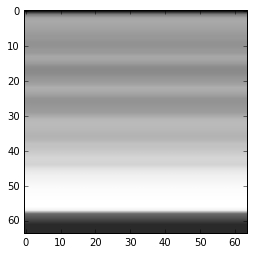

In [451]:
# Testing manual broadcast on numpy

r=np.ndarray([64,64])
r.fill(0.299)
r.shape
g=np.ndarray([64,64])
g.fill(0.587)
g.shape
b=np.ndarray([64,64])
b.fill(0.114)
b.shape


_r = np.dot(im1[...,:1].squeeze(3), r).reshape(1,64,64,1)
_g = np.dot(im1[...,1:2].squeeze(3), g).reshape(1,64,64,1)
_b = np.dot(im1[...,2:3].squeeze(3), b).reshape(1,64,64,1)
plt.imshow(np.sum([_r, _g], axis=0)[0].squeeze(2), cmap='gray')

torch.Size([1, 3, 64, 64])


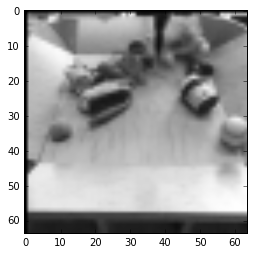

In [457]:
lap = Laplacian()
lap.laploss(np2ten(im1), np2ten(im2))
# _=lap.make_laplacian_pyramid(np2ten(im1), 2)

In [ ]:
#######Plot code for 3-channel

#         plt.subplot(max_levels+1, 3, 1)            
#         plt.imshow(np.transpose(x_pred.squeeze(0).data.numpy(), (1, 2, 0)))
#         plt.xticks([])
#         plt.yticks([])          
#         plt.subplot(max_levels+1, 3, 2)            
#         plt.imshow(np.transpose(x.squeeze(0).data.numpy(), (1, 2, 0)))
#         plt.xticks([])
#         plt.yticks([])          
#         plt.subplot(max_levels+1, 3, 3)            
#         plt.imshow(np.transpose((x_pred.squeeze(0).data.numpy())-(x.squeeze(0).data.numpy()), (1, 2, 0)))
#         plt.xticks([])
#         plt.yticks([])  
        
#         _ = 4
#         for e in range(max_levels):
#             plt.subplot(max_levels+1, 3, _)            
#             _1 = np.transpose(t_pyr1[e].squeeze(0).data.numpy(), (1, 2, 0))
#             plt.imshow(_1)
#             plt.xticks([])
#             plt.yticks([])  

#             _+=1
#             plt.subplot(max_levels+1, 3, _)            
#             _2 = np.transpose(t_pyr2[e].squeeze(0).data.numpy(), (1, 2, 0))
#             plt.imshow(_2)
#             plt.xticks([])
#             plt.yticks([])  
            
#             _+=1
#             plt.subplot(max_levels+1, 3, _)            
#             plt.imshow(_1-_2)

#             plt.xticks([])
#             plt.yticks([])  

#             _+=1
#         plt.show()
